<a href="https://colab.research.google.com/github/tedteske/Covid-19-Model/blob/master/covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

Corona Virus Analysis and Predictions

Datasets used in this study (all open): 

For country-level case and population data
* https://covid.ourworldindata.org/data/ecdc/full_data.csv
* https://covid.ourworldindata.org/data/ecdc/locations.csv

For U.S. state-level case and population data
* https://github.com/nytimes/covid-19-data
* https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-total.html


We forecast each day's new confirmed cases according to the formula:

$ c_t = contagious_{t-1} \times R_{0,t}/days_{contagious} \times (1 - immune_{t-1}) $

where
* $ c_t          => \text{new confirmed cases @ time t} $
* $ C_t          => \text{cumulative confirmed cases @ time t} $
* $ contagious_t => C_t - C_{t - days_{contagious}}$
* $ days_{contagious} => \text{number of days each case is assumed to be contagious} = 12 \text{, by default}$
* $ immune       => \text{fraction of the population that is immune} = prevalence/(1 - unreported)$
* $ prevalance   => \text{cumulative confirmed cases as a fraction of the total population} = C_t/population$
* $ unreported   => \text{fraction of all cases that are not reported} $
* $ R_{0,t}      => \text{depicts the average number of people infected from 1 other person} \geq 0$

We assume that the path of $R_0$ (basic reproduction number) follows a sigmoid curve from the most recent $R_0$ to some target. 

$R_{0,t}=f(x)   => \frac{R_{0,target}-R_{0,t-1}}{1 + e^{(-k \times (x - offset)}}$

where
* $R_{0,target} => \text{assumed target basic reproduction number}$
* $e            => \text{base of the natural logarithm} \approx 2.71828$
* $offset       => x \text{ value of the sigmoid's midpoint, default 0}$
* $k            => \text{logistic growth rate or steepness of the curve, default 1}$
* $x            => \text{real number in the closed interval -7 to 7}$

Our approach basically follows a sigmod logistic curve with an interval [-7 .. 7]. To generate a path for $R_0$, we evenly divide the closed interval [-7 .. 7] by the number of days we assume it will take to get from $R_{0,t-1}$ to $R_{0,target}$ and insert the results into the formula as $x$. Rather than merely guessing the number of days, we take the average daily rate of the progress towards $R_{0,target}$ over the last several days.

$r_\Delta       => \overline{\% \Delta (R_{0,target} - R_{0,t})}$

and calculate the number of days to get from $R_{0,t-1}$ to $R_{0,target}$:

$days           => \log_{1+r_\Delta}(2)=\ln(2)/\ln(1+r\Delta) \text{, rounded}$

This assumes that the recent daily percent progess holds true in the near future. Our approach differs from other research being conducted as our work has shown that adjusting the sigmoid's logistic growth rate (k) from its default value of 1 provides the best possible results, based on the data available for our study.

Please watch this video for a more detailed discussion on R0 

-> https://www.youtube.com/watch?v=-3xZVhFhP8w&feature=youtu.be


## Loading Functions and Data. Run these first.

Run imports and functions.

In [49]:
import pandas as pd
import math
from datetime import date
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn'
sns.set(style='darkgrid') 
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.figsize"] = [13, 13/1.6]


def load_df(covid_data, pop_data, case_start=10, contagious_days=14):
    '''
    [1] https://covid.ourworldindata.org/data/ecdc/locations.csv
    [2] https://covid.ourworldindata.org/data/ecdc/locations.csv
    '''
    try:
        population_cols = ['location', 'continent', 'population']
        latest_pops = pop_data[population_cols].groupby('location').max()
        covid_data = covid_data.merge(latest_pops, 
                                      left_on='location', right_on='location')
    except:
        population_cols = ['location', 'population']
        latest_pops = pop_data[population_cols].groupby('location').max()
        covid_data = covid_data.merge(latest_pops, 
                                      left_on='location', right_on='location')
        covid_data['continent'] = 'NA'
    covid_data.rename(columns={'continent': 'region'}, inplace=True) 
    df = munge_data(covid_data, case_start, contagious_days)
    df = order_columns(df)
    return df


def munge_data(df, case_start, contagious_days):
    '''
    Indexes dataframe by location and date, and creates all calculated fields.
    '''

    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['contagious_days'] = contagious_days

    df.set_index(['location', 'date'], inplace=True)
    df['day'] = df.index.get_level_values('date').day_name().str.slice(stop=3)
    df.index.names = ['location', None]
    
    df['source'] = 'actual'
    df['prevalence'] = df['total_cases']/df['population']       
    
    df['contagious'] = (df['total_cases'] 
                        - df['total_cases'].shift(contagious_days))
    df.loc[df['contagious'] < 0, 'contagious'] = df.loc[df['contagious'] < 0, 
                                                        'total_cases']
    
    df['R0'] = df['new_cases']/df['contagious'] * contagious_days
    
    np.seterr(divide = 'ignore') 
    df['growth'] = np.log(1 + df['total_cases'].pct_change())
    df['delta_days'] = np.log(2)/df['growth']
    df.loc[df.groupby('location').head(1).index,
           ['growth', 'delta_days']] = np.NaN
    np.seterr(divide = 'warn') 
    
    df['fatality'] = df['total_deaths']/df['total_cases']
    
    return df


def order_columns(df):
    '''
    Re-orders dataframe columns after each load and forecast.
    '''

    column_names = ['day', 'new_cases',  'total_cases', 'prevalence', 
                    'growth', 'delta_days', 'contagious', 'R0',  
                    'new_deaths', 'total_deaths', 'fatality', 
                    'source', 'population', 'region']
    return df.reindex(columns=column_names)
   

def create_repro_path(days, last, move=[]):
    '''
    [1] https://en.wikipedia.org/wiki/Logistic_function
    [2] https://en.wikipedia.org/wiki/Sigmoid_function
    [3] https://ibguides.com/biology/notes/populations/
    '''
    
    if isinstance(move, (int, float)):
        move = [move]

    move_full_spec = [last, None, 0, 1]
    move_full_spec[:len(move)] = move
    target, rate, offset, k = move_full_spec
    
    if rate:
        days_motion = int(round(np.log(2)/np.log(1 + rate)))
    else:
        days_motion = days
    
    L = target - last

    y = []
    for x in np.linspace(-7, 7, days_motion):
        fx = L / (1 + math.e**(-k * (x - offset)))
        fx += last
        y.append(fx)
    
    days_flat = max(days - days_motion, 0)
    flat_values = np.ones(days_flat) * y[-1]
    y = y + list(flat_values)
    return pd.Series(y)


def forecast(df, days, repro_move=[], unreported=0.0,
             contagious_days=12, replace=True):
    '''
    Forecasts reproduction numbers
    '''

    if replace:
        df = df[df['source'] != 'forecast']
    
    if days > 0:        
        
        last_repro = df.iloc[-1]['R0']
        new_repros = create_repro_path(days, last_repro, repro_move)

        for i in range(days):

            last = df.iloc[-1]
            R0_ = new_repros[i]  
            
            trans_rate = last['R0']/contagious_days

            # adjust for herd immunity
            immune = last['prevalence']/(1 - unreported)

            new_cases_ = last['contagious'] * trans_rate * (1 - immune)
            total_cases_ = last['total_cases'] + new_cases_
            prevalence_ = total_cases_/last['population']
            contagious_ = (total_cases_ 
                           - df.iloc[-contagious_days]['total_cases'])
                     
            growth_ = np.log(total_cases_/last['total_cases'])
            delta_days_ = np.log(2)/growth_
            total_deaths_ = total_cases_ * last['fatality']
            new_deaths_ = total_deaths_ - last['total_deaths']

            data = {'source': 'forecast',
                    'new_cases': new_cases_,
                    'total_cases': total_cases_,
                    'prevalence': prevalence_,
                    'R0': R0_,
                    'contagious': contagious_,
                    'growth': growth_,
                    'delta_days': delta_days_,
                    'new_deaths': new_deaths_,
                    'total_deaths': total_deaths_,
                    'fatality': last['fatality'],
                    'population': last['population'],
                    'region': last['region']}
            
            next_date = df.index[-1] + pd.Timedelta(days=1)
            df = df.append(pd.DataFrame(data, index=[next_date]))
        
        df['day'] = df.index.day_name().str.slice(stop=3)
        df = order_columns(df)
    return df


def plot_timeline(df, title=None, date_freq='MS',
                  left=[],
                  right=None,
                  left_ylabel=None,
                  right_ylabel=None,
                  left_yscale=1000):
    '''
    Lineplots the time series'.
    '''
    
    data = df.copy()
    
    fig, ax = plt.subplots()
    fig_width = 40
    fig.figsize = (fig_width, fig_width/1.6)
   
    for column in left:
        sns.lineplot(x=data.index, y=column, style='source', data=data, 
                     legend=False, ax=ax)
    b = min(len(ax.lines)-1, 2)
    
    # configure right axis
    if right:
        ax2 = ax.twinx()
        sns.lineplot(x=data.index, y=right, style='source', data=data,
                     legend=False, ax=ax2, color='g')
        
        yticks = np.arange(data[right].min(), data[right].max(), 0.5)
        yticks = (yticks * 2).round()/2  # limits yticks to multiples of 0.5
        
        ax2.set_yticks(yticks)
        if right_ylabel:        
            ax2.set_ylabel(right_ylabel)
        else:
            ax2.set_ylabel(right)
        handles = [ax.lines[a] for a in [0, b]] + [ax2.lines[0]]
        labels = left + [right]
    
    else:
        handles = [ax.lines[a] for a in [0, b]] 
        labels = left 
   
    ax.legend(handles, labels, loc=0)

    # configure xticks
    xticks = pd.date_range(start=data.index.min(), 
                           end=data.index.max(),
                           freq=date_freq)
    ax.set_xticks(xticks)

    # configure ylabels, yticks
    if left_ylabel:
        ax.set_ylabel(left_ylabel) 
    else:
        ax.set_ylabel(str(left) + ' (thousands)')
    ax.set_yticklabels(ax.get_yticks()/left_yscale)

    plt.title(title)
    plt.show()


def plot_cdr(df, title=None, date_freq='MS',
             left=['new_deaths', 'new_cases'],
             right='R0',
             left_ylabel='cases, deaths (thousands)',
             right_ylabel='reproduction number',
             left_yscale=1000):
    '''
    Lineplots time series of New Deaths, New Cases, and Reproduction Numbers,
    appropriately scaled, using plot_timeline().
    '''
    
    plot_timeline(df, title=title, date_freq=date_freq,
                  left=left,
                  right=right,
                  left_ylabel=left_ylabel,
                  right_ylabel=right_ylabel,
                  left_yscale=left_yscale)


def plot_growth(df, locations, column='total_cases', title=None, 
                start=10, ascending=True, rolling=1, logy=True,
                min_cases=10):
    '''
    Lineplots several user-defined time series.
    '''
    
    data = df.copy()
    
    # apply rolling mean to each location
    data = data.groupby(level=0).rolling(rolling).mean()
    
    # unless plotting total_cases itself, apply a total_cases threshold
    if column != 'total_cases':
        data = data[data['total_cases'] >= min_cases]
    
    if ascending:
        data = data[data[column] >= start]
    else:
        data = data[data[column] <= start]        

    # create column representing days since cutoff values
    data['days_since'] = data.groupby(level=0).cumcount()
    data.loc[data['days_since'] == 0, column] = start
    
    # move location to column, then pivot
    data.reset_index(level=1, inplace=True) 
    pivoted = data.pivot(index='days_since', columns='location', values=column)
    pivoted.index.name = "days since " + str(start) + " " + column

    pivoted[locations].plot(logy=logy, title=title or column)

Load country and U.S. state-level data from public sources.

In [50]:
'''
Load country-level data from https://covid.ourworldindata.org
'''

covid_data = pd.read_csv('https://covid.ourworldindata.org/data/ecdc/full_data.csv')
pop_data = pd.read_csv('https://covid.ourworldindata.org/data/ecdc/locations.csv')
df = load_df(covid_data, pop_data, case_start=1, contagious_days=12)
'''
Data Cleansing
We drop China as the data did not pass Benford's Law
Remove negative numbers
'''
df = df.drop("China", axis=0)
df = df[(df['new_cases'] >= 0) | (df['new_cases'].isnull())]
df = df[(df['new_deaths'] >= 0) | (df['new_deaths'].isnull())]
df

day  new_cases  total_cases  prevalence    growth  \
location                                                                    
Afghanistan 2019-12-31  Tue        0.0          NaN         NaN       NaN   
            2020-01-01  Wed        0.0          NaN         NaN       NaN   
            2020-01-02  Thu        0.0          NaN         NaN       NaN   
            2020-01-03  Fri        0.0          NaN         NaN       NaN   
            2020-01-04  Sat        0.0          NaN         NaN       NaN   
...                     ...        ...          ...         ...       ...   
Zimbabwe    2020-11-14  Sat       69.0       8765.0    0.000590  0.007903   
            2020-11-15  Sun       21.0       8786.0    0.000591  0.002393   
            2020-11-16  Mon        0.0       8786.0    0.000591  0.000000   
            2020-11-17  Tue      111.0       8897.0    0.000599  0.012555   
            2020-11-18  Wed       48.0       8945.0    0.000602  0.005381   

                        delta_days  contagious        R0  new_deaths  \
location                                                               
Afghanistan 2019-12-31         NaN         NaN       NaN         0.0   
            2020-01-01         NaN         NaN       NaN         0.0   
            2020-01-02         NaN         NaN       NaN         0.0   
            2020-01-03         NaN         NaN       NaN         0.0   
            2020-01-04         NaN         NaN       NaN         0.0   
...                            ...         ...       ...         ...   
Zimbabwe    2020-11-14   87.702753       391.0  2.117647         2.0   
            2020-11-15  289.652866       397.0  0.634761         0.0   
            2020-11-16         inf       376.0  0.000000         0.0   
            2020-11-17   55.210633       470.0  2.834043         0.0   
            2020-11-18  128.823981       501.0  1.149701         3.0   

                        total_deaths  fatality  source  population  region  
location                                                                    
Afghanistan 2019-12-31           NaN       NaN  actual  38928341.0    Asia  
            2020-01-01           NaN       NaN  actual  38928341.0    Asia  
            2020-01-02           NaN       NaN  actual  38928341.0    Asia  
            2020-01-03           NaN       NaN  actual  38928341.0    Asia  
            2020-01-04           NaN       NaN  actual  38928341.0    Asia  
...                              ...       ...     ...         ...     ...  
Zimbabwe    2020-11-14         257.0  0.029321  actual  14862927.0  Africa  
            2020-11-15         257.0  0.029251  actual  14862927.0  Africa  
            2020-11-16         257.0  0.029251  actual  14862927.0  Africa  
            2020-11-17         257.0  0.028886  actual  14862927.0  Africa  
            2020-11-18         260.0  0.029067  actual  14862927.0  Africa  

[56329 rows x 14 columns]

In [51]:
'''
Load US state-level data from 
https://github.com/nytimes/covid-19-data
https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-total.html
'''

covid_state_data =  pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')
#covid_state_data =  pd.read_csv('https://github.com/nytimes/covid-19-data/us-states.csv')

covid_state_data.rename({'state':'location', 'cases':'total_cases', 
                         'deaths':'total_deaths'}, axis='columns', inplace=True) 
covid_state_data.drop('fips', axis='columns', inplace=True) 

covid_state_data.set_index('location','date',inplace=True)
covid_state_data.sort_values(['location','date'], inplace=True)
covid_state_data['new_cases'] = np.nan 
covid_state_data['new_deaths'] = np.nan 

for idx in covid_state_data.index:
    covid_state_data.new_cases[idx] = covid_state_data.total_cases[idx].diff()
    covid_state_data.new_deaths[idx] = covid_state_data.total_deaths[idx].diff()

covid_state_data.reset_index(inplace=True)

pop_state_data = pd.read_csv('http://www2.census.gov/programs-surveys/popest/'
                            'datasets/2010-2019/national/totals/'
                            'nst-est2019-popchg2010_2019.csv')
pop_state_data = pop_state_data[['NAME', 'POPESTIMATE2019']]

pop_state_data.rename({'NAME':'location', 'POPESTIMATE2019':'population'}, 
                      axis='columns', inplace=True) 

df_states = load_df(covid_state_data, pop_state_data,  
                    case_start=10, contagious_days=12)

'''
Data Cleansing
'''
df_states = df_states[(df_states['new_cases'] >= 0) | (df_states['new_cases'].isnull())]
df_states = df_states[(df_states['new_deaths'] >= 0) | (df_states['new_deaths'].isnull())]
df_states

day  new_cases  total_cases  prevalence    growth  \
location                                                                 
Alabama  2020-03-13  Fri        NaN            6    0.000001       NaN   
         2020-03-14  Sat        6.0           12    0.000002  0.693147   
         2020-03-15  Sun       11.0           23    0.000005  0.650588   
         2020-03-16  Mon        6.0           29    0.000006  0.231802   
         2020-03-17  Tue       10.0           39    0.000008  0.296266   
...                  ...        ...          ...         ...       ...   
Wyoming  2020-11-13  Fri      862.0        21341    0.036874  0.041230   
         2020-11-14  Sat      540.0        21881    0.037807  0.024989   
         2020-11-15  Sun      613.0        22494    0.038866  0.027630   
         2020-11-16  Mon      699.0        23193    0.040074  0.030602   
         2020-11-17  Tue     1260.0        24453    0.042251  0.052902   

                     delta_days  contagious        R0  new_deaths  \
location                                                            
Alabama  2020-03-13         NaN         NaN       NaN         NaN   
         2020-03-14    1.000000         NaN       NaN         0.0   
         2020-03-15    1.065417         NaN       NaN         0.0   
         2020-03-16    2.990260         NaN       NaN         0.0   
         2020-03-17    2.339612         NaN       NaN         0.0   
...                         ...         ...       ...         ...   
Wyoming  2020-11-13   16.811664      7618.0  1.357837         0.0   
         2020-11-14   27.738564      7714.0  0.840031        17.0   
         2020-11-15   25.086827      7875.0  0.934095         0.0   
         2020-11-16   22.650461      8149.0  1.029329         0.0   
         2020-11-17   13.102377      9044.0  1.671827        11.0   

                     total_deaths  fatality  source  population region  
location                                                                
Alabama  2020-03-13             0  0.000000  actual     4903185     NA  
         2020-03-14             0  0.000000  actual     4903185     NA  
         2020-03-15             0  0.000000  actual     4903185     NA  
         2020-03-16             0  0.000000  actual     4903185     NA  
         2020-03-17             0  0.000000  actual     4903185     NA  
...                           ...       ...     ...         ...    ...  
Wyoming  2020-11-13           127  0.005951  actual      578759     NA  
         2020-11-14           144  0.006581  actual      578759     NA  
         2020-11-15           144  0.006402  actual      578759     NA  
         2020-11-16           144  0.006209  actual      578759     NA  
         2020-11-17           155  0.006339  actual      578759     NA  

[13512 rows x 14 columns]

## United States

This is the last one week.

In [52]:
US_Cov = df[df['total_cases']>100].loc['United States']
US_Cov[US_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,prevalence,growth,delta_days,contagious,R0,new_deaths,total_deaths,fatality,source,population,region
2020-11-12,Thu,143306.0,10401132.0,0.031423,0.013874,49.961163,1353705.0,1.270345,2117.0,241800.0,0.023247,actual,331002647.0,North America
2020-11-13,Fri,153669.0,10554801.0,0.031887,0.014666,47.261600,1428440.0,1.290938,630.0,242430.0,0.022969,actual,331002647.0,North America
2020-11-14,Sat,184813.0,10739614.0,0.032446,0.017358,39.931696,1532252.0,1.447383,1915.0,244345.0,0.022752,actual,331002647.0,North America
2020-11-15,Sun,165277.0,10904891.0,0.032945,0.015272,45.386037,1613646.0,1.229095,1255.0,245600.0,0.022522,actual,331002647.0,North America
2020-11-16,Mon,132170.0,11037061.0,0.033344,0.012047,57.535062,1653082.0,0.959444,614.0,246214.0,0.022308,actual,331002647.0,North America
2020-11-17,Tue,168425.0,11205486.0,0.033853,0.015145,45.768336,1719000.0,1.175742,1006.0,247220.0,0.022062,actual,331002647.0,North America
2020-11-18,Wed,154316.0,11359802.0,0.034319,0.013678,50.677901,1750880.0,1.057635,1467.0,248687.0,0.021892,actual,331002647.0,North America


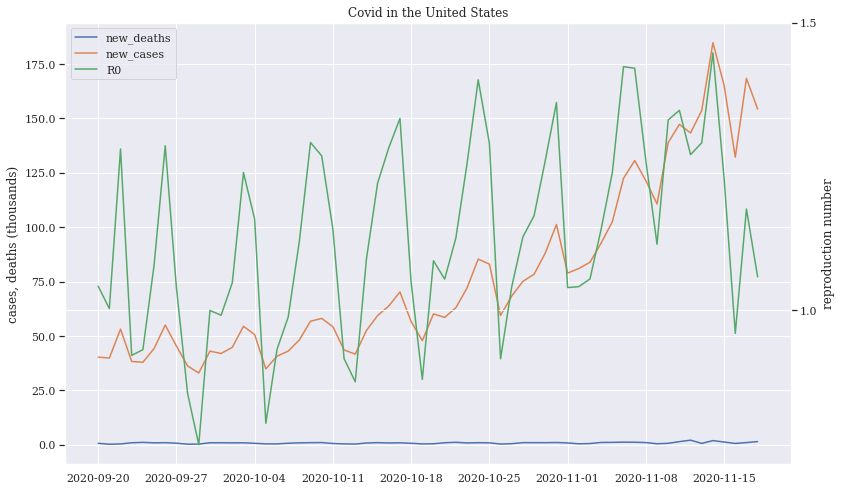

In [53]:
import warnings
warnings.filterwarnings('ignore')
plot_cdr(US_Cov[US_Cov['source']=='actual'][-60:],'Covid in the United States','W')

Now let's forecast the next 100 days. Start with estimating the daily percent change in the reproduction number. Assume a target of 0.7.

In [54]:
days_back = 14
target = 0.7
repros = US_Cov[US_Cov['source']=='actual'].R0 - target
repros.pct_change().tail(days_back).mean()

0.04234409135395571

Plug this estimate into forecast model, print the results, and plot.

In [55]:
US_Cov = forecast(US_Cov, 100, repro_move=[0.7, 0.03, -4])
default_scenario = US_Cov.copy()
default_scenario.tail(7)

,day,new_cases,total_cases,prevalence,growth,delta_days,contagious,R0,new_deaths,total_deaths,fatality,source,population,region
2021-02-20,Sat,755.677668,1.437598e+07,0.043432,0.000053,13186.053378,12772.101819,0.700006,16.543177,314716.630368,0.021892,forecast,331002647.0,North America
2021-02-21,Sun,712.687101,1.437669e+07,0.043434,0.000050,13982.173879,12045.520935,0.700006,15.602034,314732.232402,0.021892,forecast,331002647.0,North America
2021-02-22,Mon,672.142157,1.437736e+07,0.043436,0.000047,14826.320298,11360.270305,0.700006,14.714430,314746.946832,0.021892,forecast,331002647.0,North America
2021-02-23,Tue,633.903708,1.437800e+07,0.043438,0.000044,15721.390223,10713.998950,0.700006,13.877320,314760.824153,0.021892,forecast,331002647.0,North America
2021-02-24,Wed,597.840533,1.437859e+07,0.043440,0.000042,16670.456221,10104.489692,0.700006,13.087831,314773.911984,0.021892,forecast,331002647.0,North America
2021-02-25,Thu,563.828887,1.437916e+07,0.043441,0.000039,17676.776194,9529.651596,0.700006,12.343253,314786.255237,0.021892,forecast,331002647.0,North America
2021-02-26,Fri,531.752067,1.437969e+07,0.043443,0.000037,18743.804408,8987.512774,0.700006,11.641033,314797.896270,0.021892,forecast,331002647.0,North America


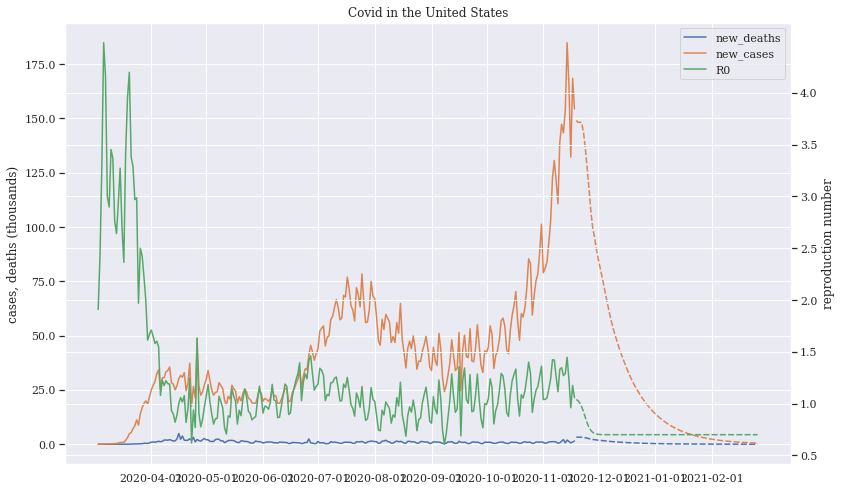

In [56]:
plot_cdr(default_scenario, 'Covid in the United States')

### Scenario: Relax on XYZ (Change Date Below) 

In [57]:
forecast_days = 100
relax_date = date(2020, 11, 30) 
relax_days = 7

last_actual = US_Cov[US_Cov['source']=='actual'].index.max().date()

stage_1 = (relax_date - last_actual).days # days until start of relation period
US_Cov = forecast(US_Cov, stage_1, repro_move=[0.7, 0.03, -4], replace=True)

stage_2 = relax_days # days during relation period
US_Cov = forecast(US_Cov, stage_2, repro_move=[1.0, None, 0], replace=False)

stage_3 = forecast_days - stage_1 - stage_2 # days during retrenchment
US_Cov = forecast(US_Cov, stage_3, repro_move=[0.7, 0.10,  0], replace=False)

relax_scenario = US_Cov.copy()
relax_scenario.tail(7)

,day,new_cases,total_cases,prevalence,growth,delta_days,contagious,R0,new_deaths,total_deaths,fatality,source,population,region
2021-02-20,Sat,1092.507125,1.493091e+07,0.045108,0.000073,9472.649530,18486.869250,0.700273,23.916994,326865.058322,0.021892,forecast,331002647.0,North America
2021-02-21,Sun,1030.157790,1.493194e+07,0.045111,0.000069,10046.686886,17431.845644,0.700273,22.552052,326887.610375,0.021892,forecast,331002647.0,North America
2021-02-22,Mon,971.364746,1.493291e+07,0.045114,0.000065,10655.489069,16437.006276,0.700273,21.264964,326908.875339,0.021892,forecast,331002647.0,North America
2021-02-23,Tue,915.925926,1.493382e+07,0.045117,0.000061,11301.154633,15498.933855,0.700273,20.051306,326928.926645,0.021892,forecast,331002647.0,North America
2021-02-24,Wed,863.650836,1.493469e+07,0.045120,0.000058,11985.905472,14614.401177,0.700273,18.906908,326947.833554,0.021892,forecast,331002647.0,North America
2021-02-25,Thu,814.359582,1.493550e+07,0.045122,0.000055,12712.098017,13780.357216,0.700273,17.827832,326965.661386,0.021892,forecast,331002647.0,North America
2021-02-26,Fri,767.882098,1.493627e+07,0.045124,0.000051,13482.235392,12993.918421,0.700273,16.810354,326982.471740,0.021892,forecast,331002647.0,North America


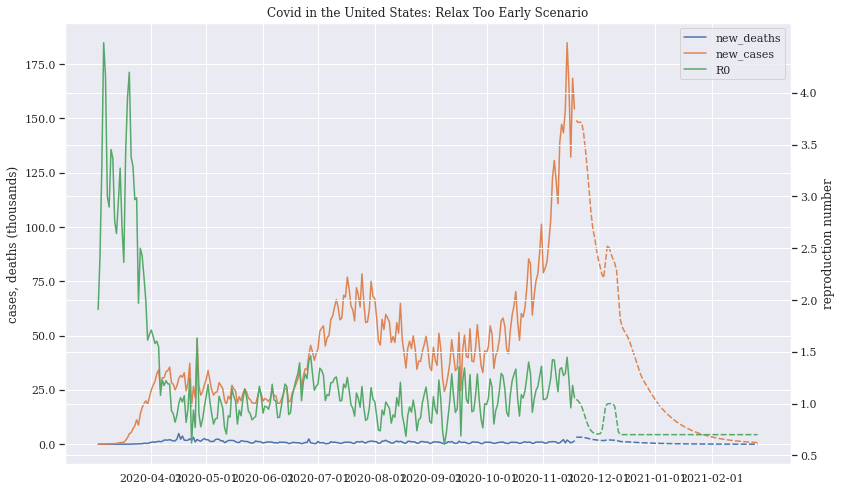

In [58]:
plot_cdr(relax_scenario, 'Covid in the United States: Relax Too Early Scenario')

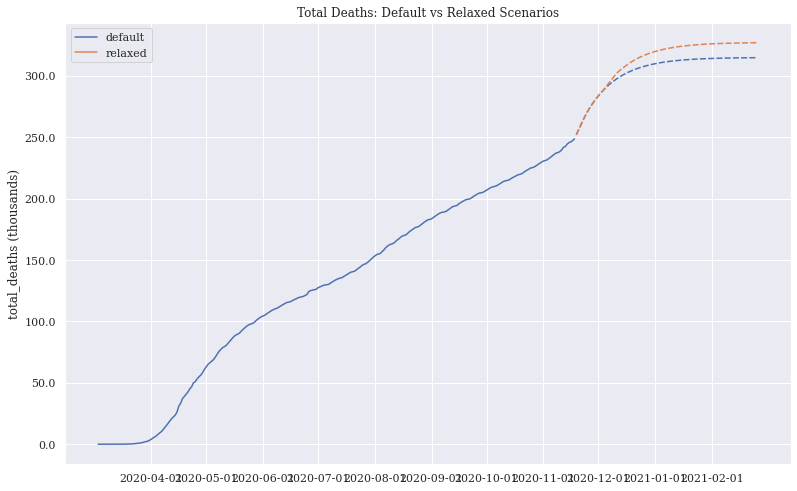

In [59]:
column = 'total_deaths'

relaxed = relax_scenario[relax_scenario['source']=='forecast'][column]
default = default_scenario[[column,'source']]

compare = pd.concat([default, relaxed], axis=1)
compare.columns = ['default','source','relaxed']

plot_timeline(compare, 'Total Deaths: Default vs Relaxed Scenarios',
              date_freq='MS',
              left=['default','relaxed'], right=None,
              left_ylabel=column + ' (thousands)')

### Scenario: No Further Improvements on Today's Reproduction Number

In [60]:
US_Cov = forecast(US_Cov, 100)
no_improvements_scenario = US_Cov.copy()
no_improvements_scenario.tail(7)

,day,new_cases,total_cases,prevalence,growth,delta_days,contagious,R0,new_deaths,total_deaths,fatality,source,population,region
2021-02-20,Sat,145080.818777,2.627827e+07,0.079390,0.005536,125.201826,1.780278e+06,1.057635,3176.086483,575279.826831,0.021892,forecast,331002647.0,North America
2021-02-21,Sun,144450.162004,2.642272e+07,0.079826,0.005482,126.443111,1.773253e+06,1.057635,3162.280244,578442.107075,0.021892,forecast,331002647.0,North America
2021-02-22,Mon,143811.988597,2.656654e+07,0.080261,0.005428,127.698899,1.766127e+06,1.057635,3148.309452,581590.416527,0.021892,forecast,331002647.0,North America
2021-02-23,Tue,143166.466943,2.670970e+07,0.080693,0.005375,128.969393,1.758903e+06,1.057635,3134.177793,584724.594320,0.021892,forecast,331002647.0,North America
2021-02-24,Wed,142513.766120,2.685222e+07,0.081124,0.005321,130.254801,1.751581e+06,1.057635,3119.888969,587844.483290,0.021892,forecast,331002647.0,North America
2021-02-25,Thu,141854.055863,2.699407e+07,0.081552,0.005269,131.555331,1.744164e+06,1.057635,3105.446696,590949.929986,0.021892,forecast,331002647.0,North America
2021-02-26,Fri,141187.506509,2.713526e+07,0.081979,0.005217,132.871194,1.736654e+06,1.057635,3090.854703,594040.784688,0.021892,forecast,331002647.0,North America


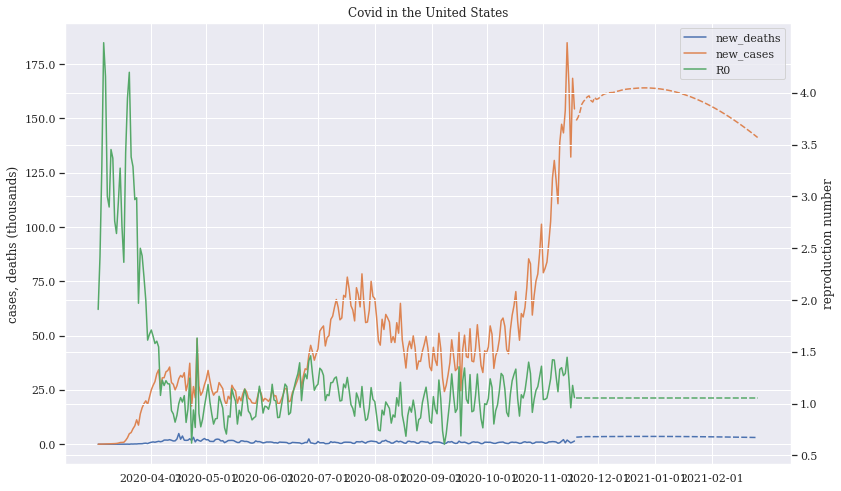

In [61]:
plot_cdr(US_Cov, 'Covid in the United States')

### Scenario: What if 90% of infections go unreported?

In [62]:
US_Cov = forecast(US_Cov, 100, repro_move=[0.7, 0.025, -4], unreported=0.9)
unreported_scenario = US_Cov.copy()
unreported_scenario.tail(7)

,day,new_cases,total_cases,prevalence,growth,delta_days,contagious,R0,new_deaths,total_deaths,fatality,source,population,region
2021-02-20,Sat,2.924094,1.256561e+07,0.037962,2.327061e-07,2.978637e+06,71.940007,0.700006,0.064014,275084.353849,0.021892,forecast,331002647.0,North America
2021-02-21,Sun,2.603436,1.256561e+07,0.037962,2.071874e-07,3.345509e+06,64.051052,0.700006,0.056994,275084.410843,0.021892,forecast,331002647.0,North America
2021-02-22,Mon,2.317942,1.256561e+07,0.037962,1.844671e-07,3.757565e+06,57.027239,0.700006,0.050744,275084.461587,0.021892,forecast,331002647.0,North America
2021-02-23,Tue,2.063758,1.256562e+07,0.037962,1.642385e-07,4.220370e+06,50.773689,0.700006,0.045179,275084.506767,0.021892,forecast,331002647.0,North America
2021-02-24,Wed,1.837448,1.256562e+07,0.037962,1.462282e-07,4.740174e+06,45.205920,0.700006,0.040225,275084.546992,0.021892,forecast,331002647.0,North America
2021-02-25,Thu,1.635956,1.256562e+07,0.037962,1.301930e-07,5.323997e+06,40.248711,0.700006,0.035814,275084.582806,0.021892,forecast,331002647.0,North America
2021-02-26,Fri,1.456559,1.256562e+07,0.037962,1.159162e-07,5.979725e+06,35.835096,0.700006,0.031887,275084.614693,0.021892,forecast,331002647.0,North America


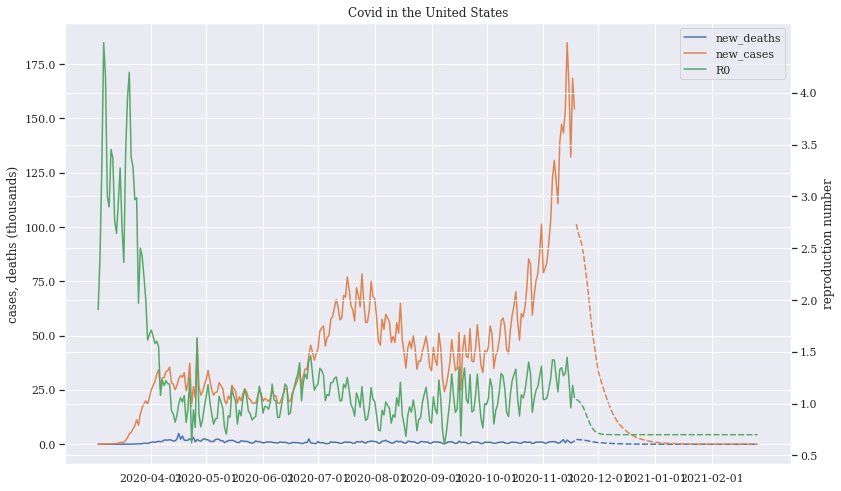

In [63]:
plot_cdr(unreported_scenario, 'Covid in the United States')

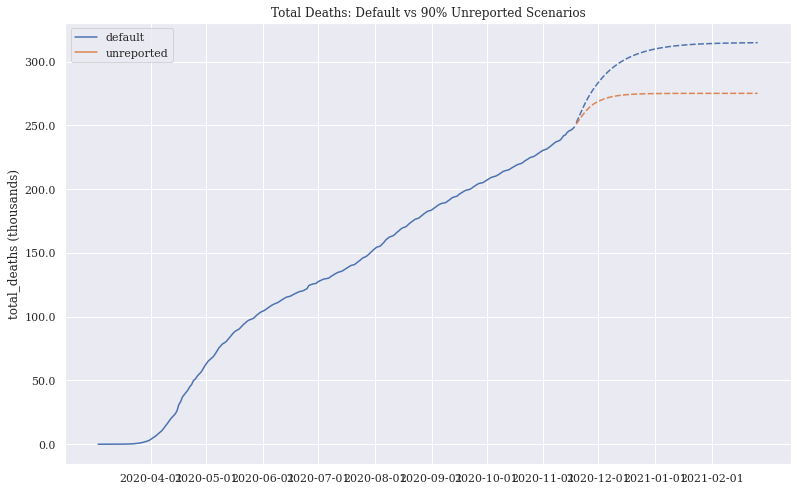

In [64]:
column = 'total_deaths'

unreported = unreported_scenario[unreported_scenario['source']=='forecast'][column]
default = default_scenario[[column,'source']]

compare = pd.concat([default, unreported], axis=1)
compare.columns = ['default','source','unreported']

plot_timeline(compare, 'Total Deaths: Default vs 90% Unreported Scenarios',
              date_freq='MS',
              left=['default','unreported'], right=None,
              left_ylabel=column + ' (thousands)')

## Other Countries

### Switzerland

In [65]:
Swiss_Cov = df[df['total_cases']>100].loc['Switzerland']
Swiss_Cov[Swiss_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,prevalence,growth,delta_days,contagious,R0,new_deaths,total_deaths,fatality,source,population,region
2020-11-12,Thu,8238.0,242578.0,0.028029,0.034550,20.061998,88850.0,1.112617,86.0,2765.0,0.011398,actual,8654618.0,Europe
2020-11-13,Fri,6893.0,249471.0,0.028825,0.028019,24.738145,95743.0,0.863938,98.0,2863.0,0.011476,actual,8654618.0,Europe
2020-11-14,Sat,6715.0,256186.0,0.029601,0.026561,26.096360,102458.0,0.786469,93.0,2956.0,0.011538,actual,8654618.0,Europe
2020-11-15,Sun,0.0,256186.0,0.029601,0.000000,inf,80616.0,0.000000,0.0,2956.0,0.011538,actual,8654618.0,Europe
2020-11-16,Mon,0.0,256186.0,0.029601,0.000000,inf,74526.0,0.000000,0.0,2956.0,0.011538,actual,8654618.0,Europe
2020-11-17,Tue,12779.0,268965.0,0.031078,0.048678,14.239576,77262.0,1.984779,197.0,3153.0,0.011723,actual,8654618.0,Europe
2020-11-18,Wed,4522.0,273487.0,0.031600,0.016673,41.573459,71686.0,0.756968,140.0,3293.0,0.012041,actual,8654618.0,Europe


In [66]:
days_back = 21
target = 0.7
repros= Swiss_Cov[Swiss_Cov['source']=='actual'].R0-target
repros.pct_change().tail(days_back).mean()

-1.0677112016668384

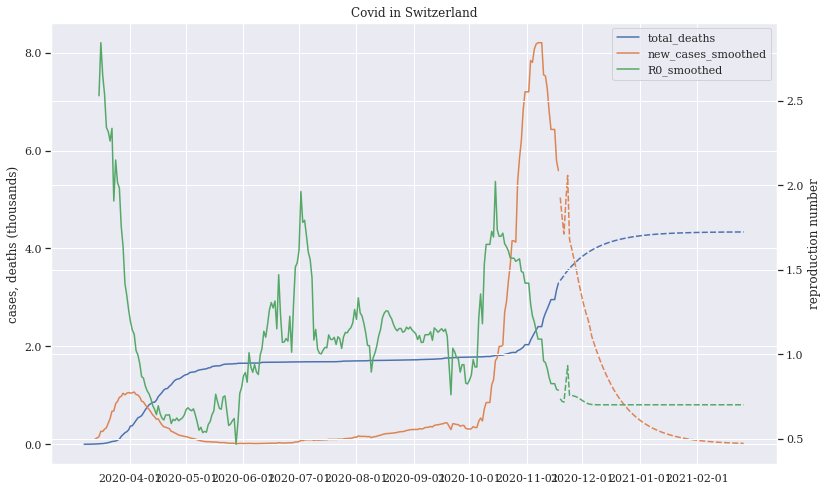

In [67]:
Swiss_Cov = forecast(Swiss_Cov, 100, repro_move=[0.7, 0.04])

Swiss_Cov['new_cases_smoothed']=Swiss_Cov['new_cases'].rolling(7).mean()
Swiss_Cov['R0_smoothed']=Swiss_Cov['R0'].rolling(7).mean()
plot_cdr(Swiss_Cov, 'Covid in Switzerland',
         left = ['total_deaths', 'new_cases_smoothed'],
         right='R0_smoothed')

### Italy

In [68]:
Italy_Cov = df[df['total_cases']>100].loc['Italy']
Italy_Cov[Italy_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,prevalence,growth,delta_days,contagious,R0,new_deaths,total_deaths,fatality,source,population,region
2020-11-12,Thu,32961.0,1028424.0,0.017009,0.032575,21.278595,380750.0,1.038823,623.0,42953.0,0.041766,actual,60461828.0,Europe
2020-11-13,Fri,37977.0,1066401.0,0.017638,0.036262,19.115030,386971.0,1.177670,636.0,43589.0,0.040875,actual,60461828.0,Europe
2020-11-14,Sat,40902.0,1107303.0,0.018314,0.037638,18.416202,397968.0,1.233325,550.0,44139.0,0.039862,actual,60461828.0,Europe
2020-11-15,Sun,37249.0,1144552.0,0.018930,0.033086,20.949886,412964.0,1.082390,544.0,44683.0,0.039040,actual,60461828.0,Europe
2020-11-16,Mon,33977.0,1178529.0,0.019492,0.029254,23.694296,418700.0,0.973786,546.0,45229.0,0.038378,actual,60461828.0,Europe
2020-11-17,Tue,27352.0,1205881.0,0.019945,0.022943,30.211220,415504.0,0.789942,504.0,45733.0,0.037925,actual,60461828.0,Europe
2020-11-18,Wed,32191.0,1238072.0,0.020477,0.026345,26.310477,413193.0,0.934895,731.0,46464.0,0.037529,actual,60461828.0,Europe


In [69]:
days_back = 21
target = 0.7
repros= Italy_Cov[Italy_Cov['source']=='actual'].R0-target
repros.pct_change().tail(days_back).mean()

0.12116023628987238

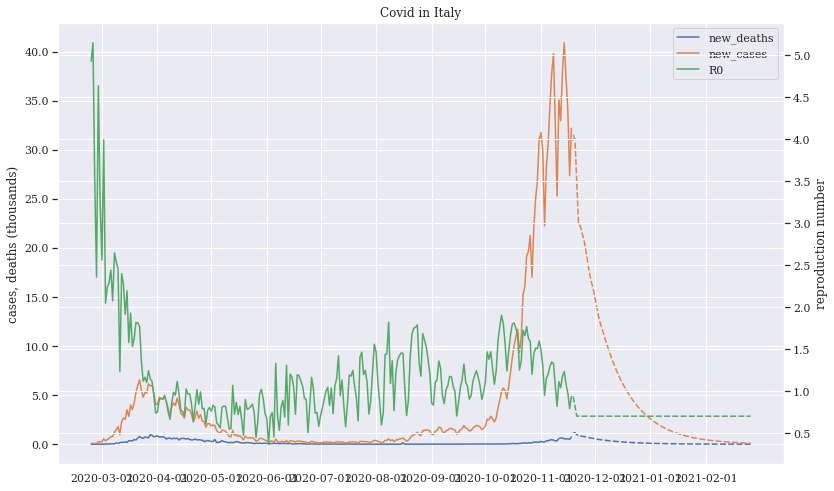

In [70]:
Italy_Cov = forecast(Italy_Cov, 100, repro_move=[0.7, 0.3])
plot_cdr(Italy_Cov, 'Covid in Italy')

### Spain

In [71]:
Spain_Cov = df[df['total_cases']>1000].loc['Spain']
Spain_Cov[Spain_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,prevalence,growth,delta_days,contagious,R0,new_deaths,total_deaths,fatality,source,population,region
2020-11-11,Wed,19096.0,1417709.0,0.030322,0.013561,51.112687,232031.0,0.987592,349.0,40105.0,0.028289,actual,46754783.0,Europe
2020-11-12,Thu,19511.0,1437220.0,0.030740,0.013669,50.711270,251542.0,0.930787,356.0,40461.0,0.028152,actual,46754783.0,Europe
2020-11-13,Fri,21371.0,1458591.0,0.031197,0.014760,46.960526,272913.0,0.939684,308.0,40769.0,0.027951,actual,46754783.0,Europe
2020-11-14,Sat,0.0,1458591.0,0.031197,0.000000,inf,217894.0,0.000000,0.0,40769.0,0.027951,actual,46754783.0,Europe
2020-11-15,Sun,0.0,1458591.0,0.031197,0.000000,inf,199225.0,0.000000,0.0,40769.0,0.027951,actual,46754783.0,Europe
2020-11-16,Mon,38273.0,1496864.0,0.032015,0.025901,26.761043,212456.0,2.161746,484.0,41253.0,0.027560,actual,46754783.0,Europe
2020-11-17,Tue,13159.0,1510023.0,0.032297,0.008753,79.193022,203707.0,0.775172,435.0,41688.0,0.027608,actual,46754783.0,Europe


In [72]:
days_back = 14
target = 0.7
repros= Spain_Cov[Spain_Cov['source']=='actual'].R0-target
repros.pct_change().tail(days_back).mean()

-1.0900737406076704

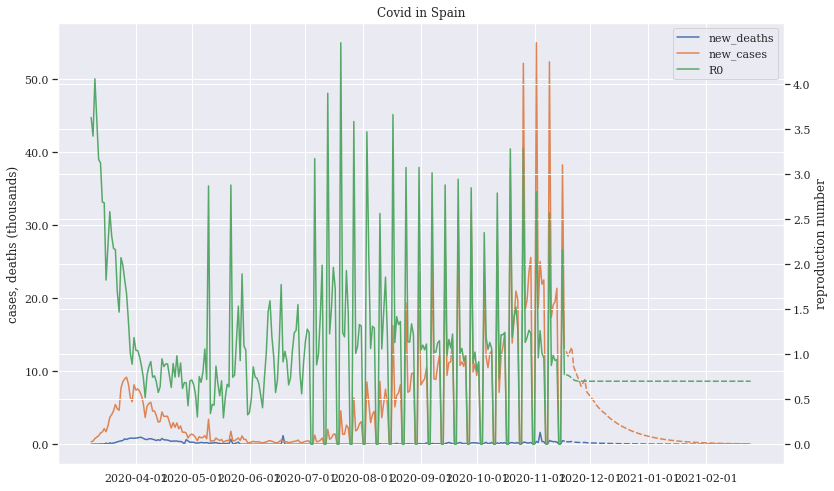

In [73]:
Spain_Cov = forecast(Spain_Cov, 100, repro_move=[0.7, 0.05,-4])
plot_cdr(Spain_Cov, 'Covid in Spain')

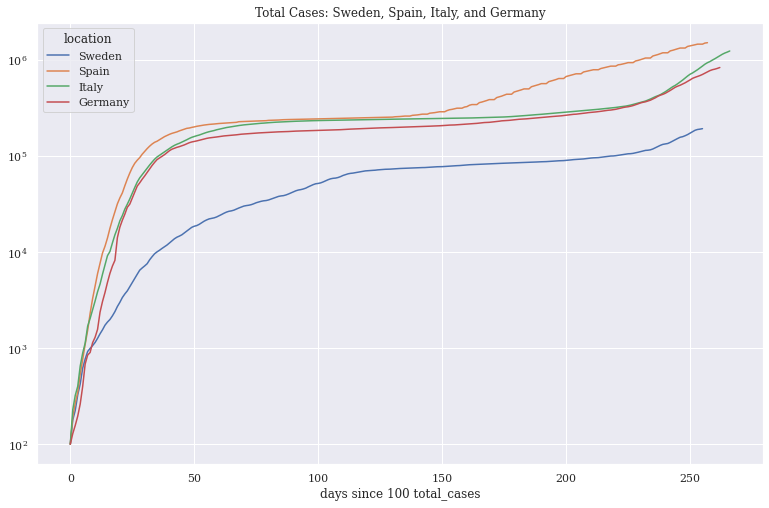

In [74]:
plot_growth(df[df['source']=='actual'], 
            ['Sweden','Spain','Italy','Germany'], 
            title='Total Cases: Sweden, Spain, Italy, and Germany',logy=True, 
            start=100, column='total_cases')

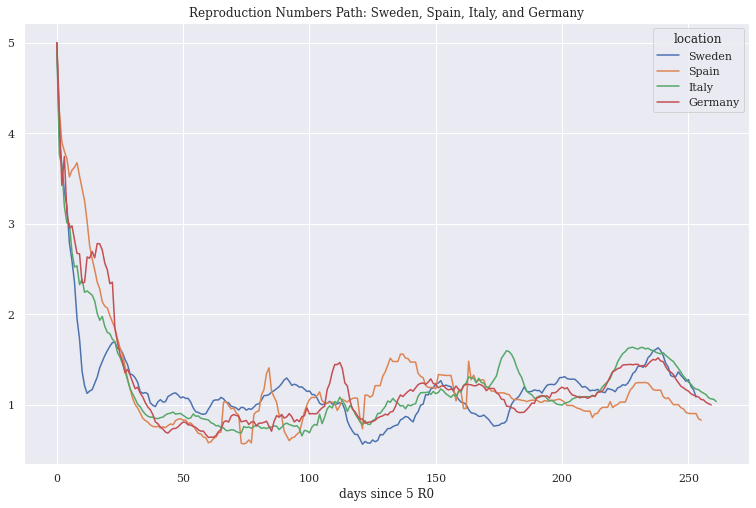

In [75]:
plot_growth(df[df['source']=='actual'],
            locations=['Sweden','Spain','Italy','Germany'], 
            column='R0', start=5, rolling=7, ascending=False, 
            logy=False, min_cases=100,
            title='Reproduction Numbers Path: Sweden, Spain, Italy, and Germany')

## The World, Country and Regional Comparisons

In [76]:
World_Cov = df.copy()
World_Cov = World_Cov[['new_cases','total_cases','new_deaths',
                       'total_deaths','population']].groupby(level=1).sum()
World_Cov['location']='world'
World_Cov.reset_index(inplace=True)
World_Cov.rename(columns = {'index':'date'}, inplace = True) 
World_Cov = munge_data(World_Cov, case_start=10, contagious_days=12)
World_Cov = order_columns(World_Cov).loc['world']
#World_Cov = World_Cov.drop("China")
World_Cov[World_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,prevalence,growth,delta_days,contagious,R0,new_deaths,total_deaths,fatality,source,population,region
2020-11-12,Thu,622321.0,52148388.0,0.008261,0.011934,58.084085,6517899.0,1.145745,10608.0,1281179.0,0.024568,actual,6.312224e+09,NaN
2020-11-13,Fri,647529.0,52799623.0,0.008365,0.012411,55.850411,6710130.0,1.158003,9120.0,1290436.0,0.024440,actual,6.312224e+09,NaN
2020-11-14,Sat,634408.0,53434031.0,0.008465,0.011944,58.034169,6855719.0,1.110445,9958.0,1300394.0,0.024336,actual,6.312224e+09,NaN
2020-11-15,Sun,597725.0,54031756.0,0.008560,0.011124,62.310292,6983165.0,1.027142,8927.0,1309321.0,0.024232,actual,6.312224e+09,NaN
2020-11-16,Mon,504446.0,54536202.0,0.008640,0.009293,74.589780,6984656.0,0.866664,6499.0,1315820.0,0.024127,actual,6.312224e+09,NaN
2020-11-17,Tue,551929.0,54549778.0,0.008658,0.000249,2784.790774,6429356.0,1.030142,8497.0,1309650.0,0.024008,actual,6.300634e+09,NaN
2020-11-18,Wed,560493.0,53600248.0,0.008571,-0.017560,-39.473192,4867697.0,1.381745,10191.0,1278153.0,0.023846,actual,6.253879e+09,NaN


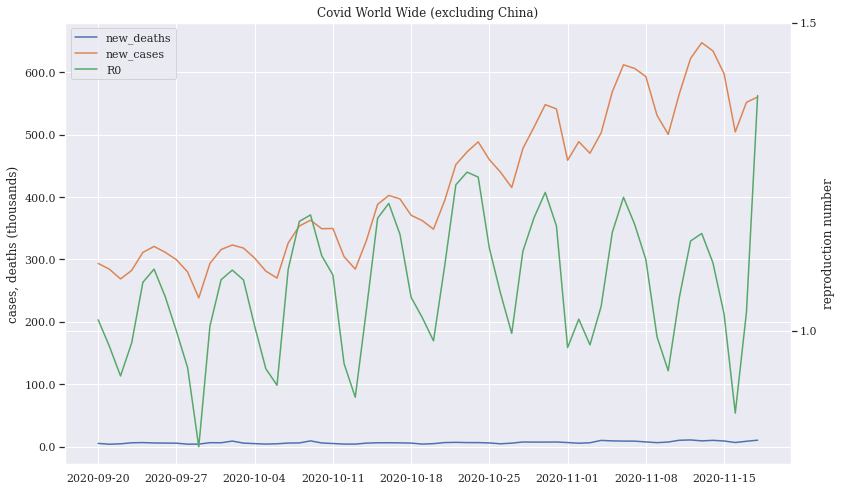

In [77]:
plot_cdr(World_Cov[World_Cov['source']=='actual'][-60:], 
         'Covid World Wide (excluding China)','W')

In [78]:
df[df['source']=='actual'].groupby('location')[['growth','delta_days']]\
    .last().sort_values('growth',ascending=False).head(10)

,growth,delta_days
location,,
Marshall Islands,1.386294,0.500000
Falkland Islands,0.064539,10.740054
Saint Vincent and the Grenadines,0.062132,11.156081
Serbia,0.055579,12.471496
Mongolia,0.047253,14.668886
Bulgaria,0.046349,14.954830
Jordan,0.042254,16.404334
French Polynesia,0.034838,19.896323
Greece,0.031208,22.210388


In [79]:
df[df['source']=='actual'].groupby('location')[['region','total_cases']]\
    .last().groupby('region').sum()\
    .sort_values('total_cases',ascending=False)

,total_cases
region,
Asia,15218658.0
Europe,14463084.0
North America,13483456.0
South America,10435308.0
Africa,1999563.0
Oceania,48555.0


In [80]:
top5 = df[df['source']=='actual']\
    .groupby('location')[['total_cases','R0']]\
    .last().sort_values('total_cases', ascending=False).head(5).reset_index()
top5.index += 1
top5

,location,total_cases,R0
1,United States,11359802.0,1.057635
2,India,8912907.0,0.924620
3,Brazil,5911758.0,1.414405
4,France,2036755.0,1.254660
5,Russia,1991998.0,0.902128


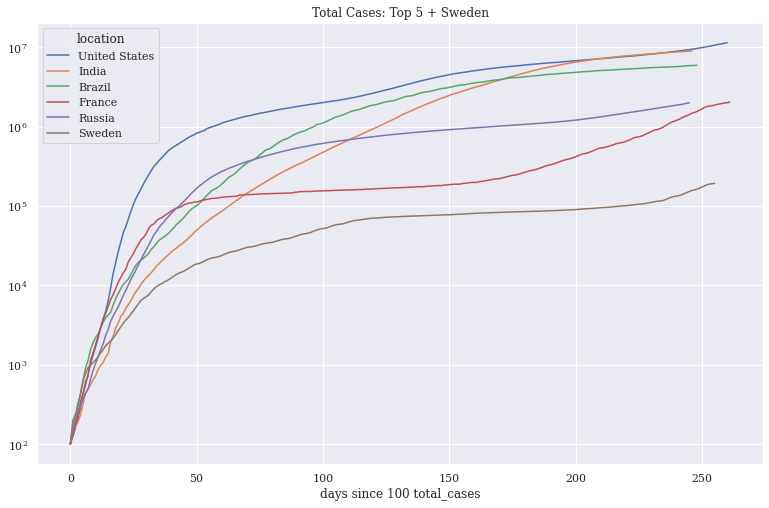

In [81]:
plot_growth(df[df['source']=='actual'], 
            locations=top5['location'].append(pd.Series('Sweden', index=[6])), 
            title='Total Cases: Top 5 + Sweden', 
            start=100, rolling=1, ascending=True, logy=True)

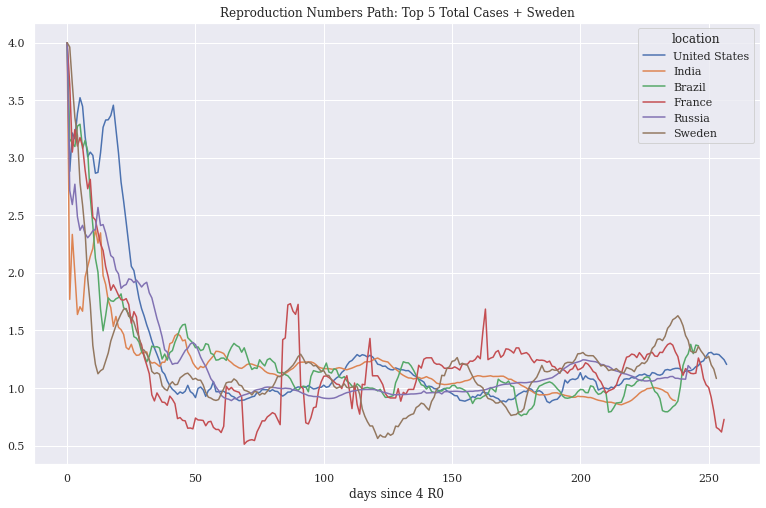

In [82]:
plot_growth(df[df['source']=='actual'],
            locations=top5['location'].append(pd.Series('Sweden', index=[6])), 
            column='R0', start=4, rolling=7, ascending=False, 
            logy=False, min_cases=100,
            title='Reproduction Numbers Path: Top 5 Total Cases + Sweden')

## U.S. States

### Texas

In [83]:
TX_Cov = df_states[df_states['total_cases']>10].loc['Texas']
TX_Cov[TX_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,prevalence,growth,delta_days,contagious,R0,new_deaths,total_deaths,fatality,source,population,region
2020-11-11,Wed,12857.0,1050992,0.036246,0.012309,56.313845,105044.0,1.468756,121.0,19544,0.018596,actual,28995881,NA
2020-11-12,Thu,9676.0,1060668,0.036580,0.009164,75.634608,107229.0,1.082841,161.0,19705,0.018578,actual,28995881,NA
2020-11-13,Fri,12562.0,1073230,0.037013,0.011774,58.871529,115441.0,1.305810,212.0,19917,0.018558,actual,28995881,NA
2020-11-14,Sat,9750.0,1082980,0.037349,0.009044,76.644138,117253.0,0.997842,118.0,20035,0.018500,actual,28995881,NA
2020-11-15,Sun,7368.0,1090348,0.037604,0.006780,102.227905,116120.0,0.761419,75.0,20110,0.018444,actual,28995881,NA
2020-11-16,Mon,11371.0,1101719,0.037996,0.010375,66.810810,116819.0,1.168063,47.0,20157,0.018296,actual,28995881,NA
2020-11-17,Tue,10859.0,1112578,0.038370,0.009808,70.670477,118705.0,1.097747,121.0,20278,0.018226,actual,28995881,NA


In [84]:
days_back = 21
target = 0.7
repros= TX_Cov[TX_Cov['source']=='actual'].R0-target
repros.pct_change().tail(days_back).mean()

-0.4979345249394606

In [85]:
TX_Cov = forecast(TX_Cov, 50, repro_move=(0.7, 0.3))
TX_Cov.tail(7)

,day,new_cases,total_cases,prevalence,growth,delta_days,contagious,R0,new_deaths,total_deaths,fatality,source,population,region
2020-12-31,Thu,753.659491,1.265710e+06,0.043651,0.000596,1163.738187,12733.033433,0.700362,13.736302,23069.011147,0.018226,forecast,28995881,NA
2021-01-01,Fri,710.705488,1.266421e+06,0.043676,0.000561,1234.786923,12007.462190,0.700362,12.953416,23081.964563,0.018226,forecast,28995881,NA
2021-01-02,Sat,670.189912,1.267091e+06,0.043699,0.000529,1310.148677,11323.368551,0.700362,12.214974,23094.179537,0.018226,forecast,28995881,NA
2021-01-03,Sun,631.992327,1.267723e+06,0.043721,0.000499,1390.048098,10678.841281,0.700362,11.518779,23105.698316,0.018226,forecast,28995881,NA
2021-01-04,Mon,596.005676,1.268319e+06,0.043741,0.000470,1474.692878,10071.846900,0.700362,10.862882,23116.561198,0.018226,forecast,28995881,NA
2021-01-05,Tue,562.116126,1.268881e+06,0.043761,0.000443,1564.315025,9499.857232,0.700362,10.245206,23126.806404,0.018226,forecast,28995881,NA
2021-01-06,Wed,530.182273,1.269412e+06,0.043779,0.000418,1659.250618,8960.509488,0.700362,9.663175,23136.469579,0.018226,forecast,28995881,NA


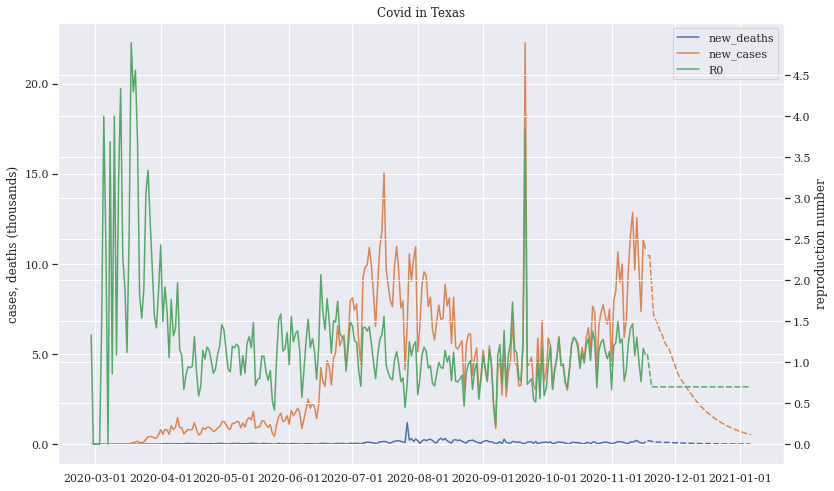

In [86]:
plot_cdr(TX_Cov, 'Covid in Texas')

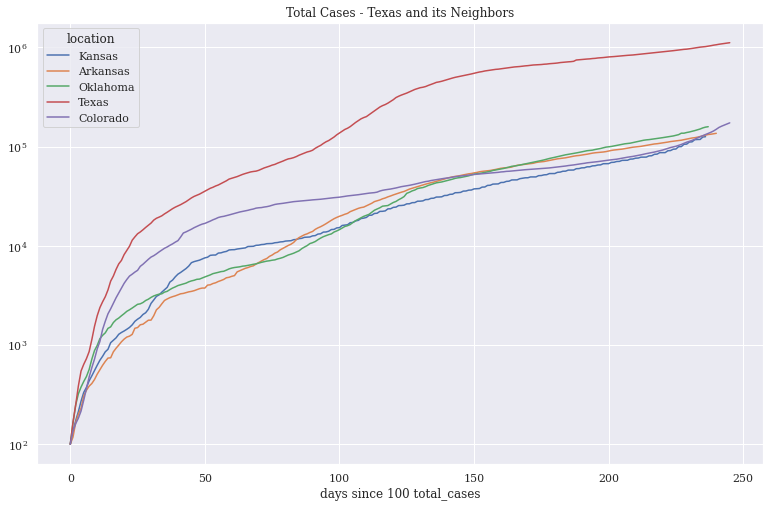

In [87]:
plot_growth(df_states, 
            ['Kansas', 'Arkansas','Oklahoma','Texas','Colorado'],
            title='Total Cases - Texas and its Neighbors', logy=True, 
            start=100, column='total_cases')

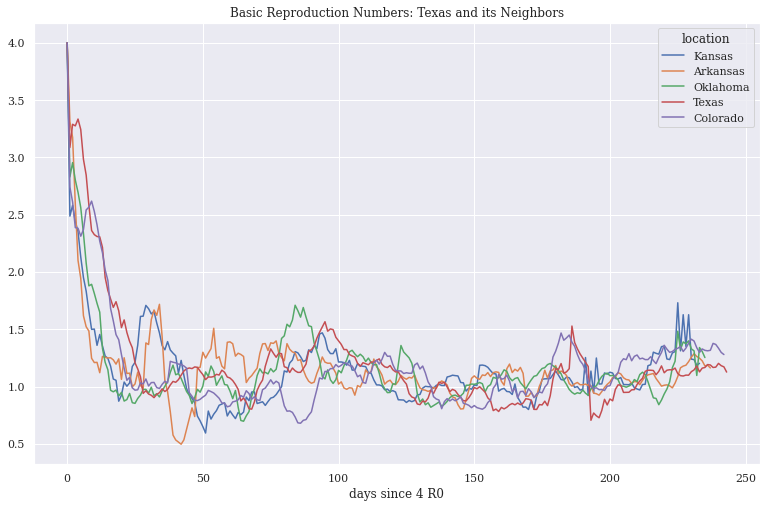

In [88]:
plot_growth(df_states[df_states['source']=='actual'],
            locations=['Kansas', 'Arkansas','Oklahoma','Texas','Colorado'], 
            column='R0', start=4, rolling=7, ascending=False, 
            logy=False, min_cases=100,
            title='Basic Reproduction Numbers: Texas and its Neighbors')

### Florida

In [89]:
FL_Cov = df_states[df_states['total_cases']>10].loc['Florida']
FL_Cov[FL_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,prevalence,growth,delta_days,contagious,R0,new_deaths,total_deaths,fatality,source,population,region
2020-11-11,Wed,5838.0,858004,0.039949,0.006827,101.524059,57796.0,1.212125,52.0,17299,0.020162,actual,21477737,NA
2020-11-12,Thu,5607.0,863611,0.040210,0.006514,106.414158,61072.0,1.101716,72.0,17371,0.020114,actual,21477737,NA
2020-11-13,Fri,6933.0,870544,0.040532,0.007996,86.688176,63140.0,1.317643,73.0,17444,0.020038,actual,21477737,NA
2020-11-14,Sat,4544.0,875088,0.040744,0.005206,133.140093,63033.0,0.865071,44.0,17488,0.019984,actual,21477737,NA
2020-11-15,Sun,10105.0,885193,0.041214,0.011481,60.372113,68501.0,1.770193,29.0,17517,0.019789,actual,21477737,NA
2020-11-16,Mon,4663.0,889856,0.041432,0.005254,131.928735,68741.0,0.814012,41.0,17558,0.019731,actual,21477737,NA
2020-11-17,Tue,7459.0,897315,0.041779,0.008347,83.038299,69943.0,1.279728,85.0,17643,0.019662,actual,21477737,NA


In [90]:
days_back = 21
target = 0.7
repros= FL_Cov[FL_Cov['source']=='actual'].R0-target
repros.pct_change().tail(days_back).mean()

0.16797195095957476

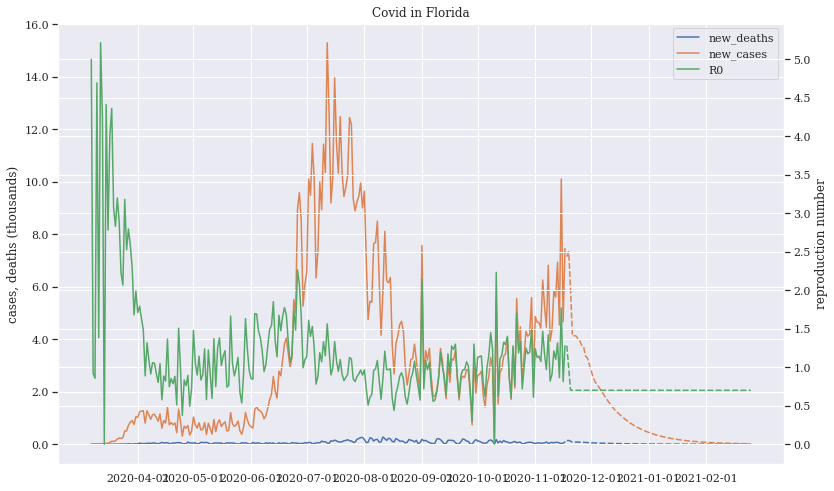

In [91]:
FL_Cov = forecast(FL_Cov, 100, repro_move=(0.7,0.3))
plot_cdr(FL_Cov, 'Covid in Florida')

In [92]:
### California

In [93]:
CA_Cov = df_states[df_states['total_cases']>10].loc['California']
CA_Cov[CA_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,prevalence,growth,delta_days,contagious,R0,new_deaths,total_deaths,fatality,source,population,region
2020-11-11,Wed,5157.0,999498,0.025296,0.005173,133.994648,67672.0,0.914470,36.0,18109,0.018118,actual,39512223,NA
2020-11-12,Thu,9689.0,1009187,0.025541,0.009647,71.849703,73939.0,1.572485,32.0,18141,0.017976,actual,39512223,NA
2020-11-13,Fri,9865.0,1019052,0.025791,0.009728,71.254793,80169.0,1.476631,77.0,18218,0.017877,actual,39512223,NA
2020-11-14,Sat,7964.0,1027016,0.025992,0.007785,89.039371,82875.0,1.153158,36.0,18254,0.017774,actual,39512223,NA
2020-11-15,Sun,8965.0,1035981,0.026219,0.008691,79.751899,86598.0,1.242292,11.0,18265,0.017631,actual,39512223,NA
2020-11-16,Mon,11100.0,1047081,0.026500,0.010657,65.038508,92457.0,1.440670,39.0,18304,0.017481,actual,39512223,NA
2020-11-17,Tue,8591.0,1055672,0.026718,0.008171,84.827680,94788.0,1.087606,32.0,18336,0.017369,actual,39512223,NA


In [94]:
days_back = 21
target = 0.7
repros= CA_Cov[CA_Cov['source']=='actual'].R0-target
repros.pct_change().tail(days_back).mean()

0.24037197824357778

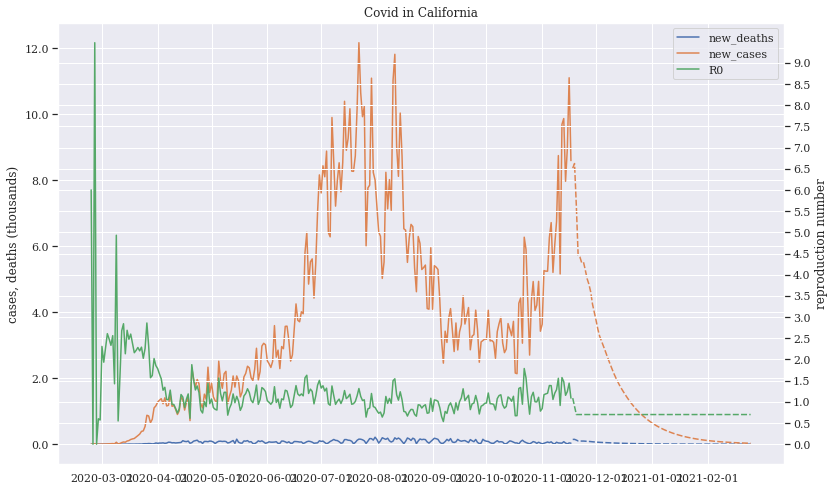

In [95]:
CA_Cov = forecast(CA_Cov, 100, repro_move=(0.7,0.3))
plot_cdr(CA_Cov, 'Covid in California')